## Imports and Mounting

In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00


In [10]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader, Subset

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

from torcheval.metrics.functional import multiclass_confusion_matrix, multiclass_recall,\
                                multiclass_precision, multiclass_f1_score, multiclass_accuracy

from sklearn.model_selection import KFold, ParameterGrid

import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

## Data Exploration

Implement data loading and preprocessing techniques including normalization, resizing, and data augmentation.

In [11]:
# Normalize the original dataset via transform module
original_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Augment and normalize the original dataset via transform module
augmented_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # Make sure to resize to the same size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [12]:
# Load CIFAR-10 dataset and apply normalization using original_transform
original_trainset = CIFAR10(root='./data', train=True,
                            download=True, transform=original_transform)
original_testset = CIFAR10(root='./data', train=False,
                            download=False, transform=original_transform)

# Load CIFAR-10 dataset and apply augmentation then normalization using augmented_transform
augmented_trainset = CIFAR10(root='./data', train=True,
                             download=False, transform=augmented_transform)
augmented_testset = CIFAR10(root='./data', train=False,
                            download=False, transform=augmented_transform)

# Concatenate original and augmented datasets to increase the size of the dataset
trainset = ConcatDataset([original_trainset, augmented_trainset])
testset = ConcatDataset([original_testset, augmented_testset])

# Print the len
print("Trainset size: {}". format(len(trainset)))
print("Testset size: {}". format(len(testset)))


100%|██████████| 170498071/170498071 [00:04<00:00, 40882374.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Trainset size: 100000
Testset size: 20000


In [ ]:
_, labels

In [13]:
batch_size = 64

# Create data loaders for train and test sets
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



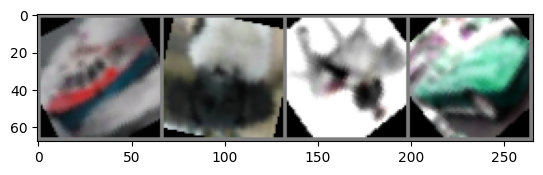

ship  dog   horse car  


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random images from training
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Model Architecture

Design a CNN model from scratch. Ensure the model is appropriate for the task but not overly complex.

In [14]:
# Create a CNN model call the layers and architecture needed
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolution layer with 3 channels input and 32 output channels.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # First convolution layer with 32 channels input and 64 output channels.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Maxpool layer for dimention reduction
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512) # Non-linearity
        self.fc2 = nn.Linear(512, 10) # Output prediction
        self.dropout = nn.Dropout(.5)  # Dropout layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16) # Flatten
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
# Create a model object from the CNN model
net = CNN()

## Training and Evaluation

Tried two different optimizers in order to choose which one would perform better for later on hypertuning

In [16]:
# Set to variables of criterion and optimizer of Cross Entropy and Mini-Batch Gradient Decent, respectively.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Set the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
batch_size = 64

# Loop over folds
for fold, (train_indices, val_indices) in enumerate(kf.split(trainset)):
    print(f"Training on Fold {fold + 1}/{num_folds}")

    # Create data loaders for the current fold
    train_subset = Subset(trainset, train_indices)
    val_subset = Subset(trainset, val_indices)

    # Create loaders for the train set and the validation dataset
    trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=64, shuffle=False)

    # Training loop
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch + 1} (Fold {fold + 1}/{num_folds})'), 0):
            inputs, labels = data
            # Reset the gradient
            optimizer.zero_grad()
            # Forward pass
            outputs = net(inputs)
            # Loss computing
            loss = criterion(outputs, labels)
            # Backward pass
            loss.backward()
            # Optimize model
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    # Validation loop
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc=f'Validation (Fold {fold + 1}/{num_folds})'):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # Set total and correct
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Print the validation loss and accuracy, respectively
    print(f'Validation loss: {val_loss / len(valloader):.3f}')
    print(f'Validation accuracy: {100 * correct / total:.2f}%')

    net.train()  # Set the model back to training mode

print('Finished Training with Cross Validation')

Training on Fold 1/5


Validation (Fold 1/5): 100%|██████████| 313/313 [01:18<00:00,  3.96it/s]


Validation loss: 1.623
Validation accuracy: 42.08%
Training on Fold 2/5


Validation (Fold 2/5): 100%|██████████| 313/313 [01:36<00:00,  3.25it/s]


Validation loss: 1.458
Validation accuracy: 48.04%
Training on Fold 3/5


Validation (Fold 3/5): 100%|██████████| 313/313 [01:34<00:00,  3.33it/s]


Validation loss: 1.362
Validation accuracy: 51.77%
Training on Fold 4/5


Validation (Fold 4/5): 100%|██████████| 313/313 [01:35<00:00,  3.29it/s]


Validation loss: 1.254
Validation accuracy: 55.56%
Training on Fold 5/5


Validation (Fold 5/5): 100%|██████████| 313/313 [01:19<00:00,  3.91it/s]

Validation loss: 1.195
Validation accuracy: 57.65%
Finished Training with Cross Validation


In [17]:
# Set to variables of criterion and optimizer of Cross Entropy and Adam optimizer, respectively.
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# Set the number of folds
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over folds
for fold, (train_indices, val_indices) in enumerate(kf.split(trainset)):
    print(f"Training on Fold {fold + 1}/{num_folds}")

    # Create data loaders for the current fold
    train_subset = Subset(trainset, train_indices)
    val_subset = Subset(trainset, val_indices)

    # Create loaders for the train set and the validation dataset
    trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=64, shuffle=False)

    # Training loop
    for epoch in range(3):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch + 1} (Fold {fold + 1}/{num_folds})'), 0):
            inputs, labels = data
            # Reset the gradient
            optimizer.zero_grad()
            # Forward pass
            outputs = net(inputs)
            # Loss computing
            loss = criterion(outputs, labels)
            # Backward pass
            loss.backward()
            # Optimize model
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    # Validation loop (optional)
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc=f'Validation (Fold {fold + 1}/{num_folds})'):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # Set total and correct
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Print the validation loss and accuracy, respectively
    print(f'Validation loss: {val_loss / len(valloader):.3f}')
    print(f'Validation accuracy: {100 * correct / total:.2f}%')

    net.train()  # Set the model back to training mode

print('Finished Training with Cross Validation')

Training on Fold 1/3


Validation (Fold 1/3): 100%|██████████| 521/521 [02:32<00:00,  3.42it/s]


Validation loss: 1.274
Validation accuracy: 54.38%
Training on Fold 2/3


Validation (Fold 2/3): 100%|██████████| 521/521 [02:32<00:00,  3.42it/s]


Validation loss: 1.100
Validation accuracy: 61.17%
Training on Fold 3/3


Validation (Fold 3/3): 100%|██████████| 521/521 [02:32<00:00,  3.43it/s]

Validation loss: 0.968
Validation accuracy: 65.61%
Finished Training with Cross Validation


In [ ]:
torch.save(net, '/content/modeladamm.pth')

## Hyperparameter tuning

In [ ]:
# Set the number of folds
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the hyperparameter grid for Adam optimizer
adam_hyperparameters = {
    'betas': [(0.9, 0.999), (0.8, 0.9)],
    'eps': [1e-8, 1e-7, 1e-6]
}

# Loop over hyperparameter combinations
for adam_params in ParameterGrid(adam_hyperparameters):
    print(f"Hyperparameters: {adam_params}")

    # Loop over folds
    for fold, (train_indices, val_indices) in enumerate(kf.split(trainset)):
        print(f"Training on Fold {fold + 1}/{num_folds}")

        # Create data loaders for the current fold
        train_subset = Subset(trainset, train_indices)
        val_subset = Subset(trainset, val_indices)

        # Create loaders for the train set and the validation dataset
        trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
        valloader = DataLoader(val_subset, batch_size=64, shuffle=False)

        # Create a new model for each hyperparameter combination
        net = CNN()

        # Set optimizer with current hyperparameters
        optimizer = optim.Adam(net.parameters(), **adam_params)

        # Training loop
        for epoch in range(3):
            running_loss = 0.0
            for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch + 1} (Fold {fold + 1}/{num_folds})'), 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if i % 2000 == 1999:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                    running_loss = 0.0

        # Validation loop
        net.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in tqdm(valloader, desc=f'Validation (Fold {fold + 1}/{num_folds})'):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Print the validation loss and accuracy
        print(f'Validation loss: {val_loss / len(valloader):.3f}')
        print(f'Validation accuracy: {100 * correct / total:.2f}%')

        net.train()


print('Finished Training with Cross Validation')


Hyperparameters: {'betas': (0.9, 0.999), 'eps': 1e-08}
Training on Fold 1/3


Validation (Fold 1/3): 100%|██████████| 521/521 [02:54<00:00,  2.99it/s]


Validation loss: 1.186
Validation accuracy: 57.68%
Training on Fold 2/3


Validation (Fold 2/3): 100%|██████████| 521/521 [02:51<00:00,  3.04it/s]


Validation loss: 1.203
Validation accuracy: 57.27%
Training on Fold 3/3


Validation (Fold 3/3): 100%|██████████| 521/521 [02:52<00:00,  3.01it/s]


Validation loss: 1.172
Validation accuracy: 58.73%
Hyperparameters: {'betas': (0.9, 0.999), 'eps': 1e-07}
Training on Fold 1/3


Validation (Fold 1/3): 100%|██████████| 521/521 [02:26<00:00,  3.55it/s]


Validation loss: 1.165
Validation accuracy: 58.82%
Training on Fold 2/3


Validation (Fold 2/3): 100%|██████████| 521/521 [02:50<00:00,  3.06it/s]


Validation loss: 1.203
Validation accuracy: 57.35%
Training on Fold 3/3


Validation (Fold 3/3): 100%|██████████| 521/521 [02:53<00:00,  3.01it/s]


Validation loss: 1.195
Validation accuracy: 57.27%
Hyperparameters: {'betas': (0.9, 0.999), 'eps': 1e-06}
Training on Fold 1/3


Validation (Fold 1/3): 100%|██████████| 521/521 [02:51<00:00,  3.04it/s]


Validation loss: 1.268
Validation accuracy: 55.04%
Training on Fold 2/3


Validation (Fold 2/3): 100%|██████████| 521/521 [02:29<00:00,  3.48it/s]


Validation loss: 1.175
Validation accuracy: 58.24%
Training on Fold 3/3


Validation (Fold 3/3): 100%|██████████| 521/521 [02:24<00:00,  3.61it/s]


Validation loss: 1.161
Validation accuracy: 58.97%
Hyperparameters: {'betas': (0.8, 0.9), 'eps': 1e-08}
Training on Fold 1/3


Epoch 2 (Fold 1/3):  90%|████████▉ | 933/1042 [16:23<01:55,  1.06s/it]

## Testing and Evaluation

In [23]:
net = torch.load('/content/drive/MyDrive/modeladam.pth')
net.eval()  # Set the model to evaluation mode

criterion = nn.CrossEntropyLoss()

test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in tqdm(testloader, desc='Testing'):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect predictions and ground truth labels for later analysis
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Print the test loss and accuracy
print(f'Test loss: {test_loss / len(testloader):.3f}')
print(f'Test accuracy: {100 * correct / total:.2f}%')

Testing: 100%|██████████| 313/313 [01:42<00:00,  3.06it/s]

Test loss: 1.162
Test accuracy: 60.27%


In [26]:
# Calculate additional metrics
accuracy = multiclass_accuracy(predicted, labels, num_classes=10)
precision = multiclass_precision(predicted, labels, num_classes=10)
recall = multiclass_recall(predicted, labels, num_classes=10)
f1 = multiclass_f1_score(predicted, labels, num_classes=10)

# Print the calculated metrics
print(f'Test accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Test accuracy: 0.56
Precision: 0.56
Recall: 0.56
F1-score: 0.56


## Report

1. **Architecture**: the technique adopted is a straightforward approach of creating a model of two convolutional layers, max-pooling layer, finishing with a fully-connected layer. In order to perserve the input size of the images, padding was used.

2. **Loss function**: as working with a classification task, Cross Entropy loss function was selected.

3. **Optimizers**: two optimizers were evaluated and compared. After 3 epochs, the Adam optimizer outperformed Mini-Batch Gradient Descent, resulting in 65.61% and 57.56% validation accuracy, respectively.

4. **Test results**: the initial model using the Adam optimizer has resulted in 56% on the testsets.

5. **Hyperparameter tuning**: to optimize the Adam optimizer parameters, hyperparameter tuning was initiated. This was taken to achieve the best possible outcome on the validation/test result.


#### Issues:
1. **Underfitting**: the model show signs of underfitting, suggesting a need for higher complexity and capacity to capture the underlying patterns in data.
2. **Computational resource limitation**: model training and validation process consumed a considerable amount of time due to limited computational power.


#### Future Enhancements:
1. **Model enhancement**: adjust the model architecture by adding more layers and add complexity to better capture data features.
2. **Extend number of epochs**: by increasing the number of epochs, it may leave room for better performance.
3. **Hyperparamters optimization**: continue the hyperparameter tuning process, focusing on the Adam optimizer, to identify the best combination that can lead to the best possible performance.
